In [1]:
import random as rn
import numpy as np
import matplotlib.pyplot as plt
import math
from typing import List, Tuple
print(plt.style.available)
plt.style.use('seaborn-v0_8')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


- nv = num_parameters
- lb = lowerbound
- ub = upperbound
- n = nP
- pop = population

In [ ]:
rate_crossover = 20         # number of chromosomes that we apply crossower to
rate_mutation = 20          # number of chromosomes that we apply mutation to
rate_local_search = 10      # number of chromosomes that we apply local_search to

In [60]:
class NSGAII:
    def __init__(
        self,
        upperbound,
        lowerbound,
        objective_function,
        robust_trial=1,
        population_size=50,
        generation_size=150,
        crossover_rate=20, #0.7
        mutation_rate=20, #0.3
        local_search_rate = 10, #0.1
        step_size=0.1
    ):
        self.robust_trial = robust_trial  # to test the robustness of the approach
        self.objective_function = objective_function
        self.upperbound = upperbound
        self.lowerbound = lowerbound
        self.num_parameters = len(
            self.upperbound
        )  # number of parameters in one candidate solution (x1, x2, ..., x6)
        self.population_size = population_size
        self.generation_size = generation_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.local_search_rate=local_search_rate
        self.step_size = step_size

    def __generate_population(
        self, pop_size: int, num_parameters:int, lowerbound: np.ndarray, upperbound: np.ndarray
    ) -> np.ndarray:
        """
        Returns: A numpy array containing the objective values
        """
        population = np.zeros((pop_size, num_parameters))
        for i in range(pop_size):
            for j in range(len(lowerbound)):
                population[i, j] = np.random.uniform(lowerbound[j], upperbound[j])
        return population

    def __check_boundaries(self, population: np.ndarray) -> np.ndarray:
        """
        numpy.clip(a, a_min, a_max, out=None, **kwargs)[source]
        """
        return np.clip(population, self.lowerbound, self.upperbound, out=population)

    def __evaluate_fitness_of_population(self, population):
        fitness_values = []
        for i in range(self.population_size):
            fitness_values.append(self.objective_function(population[i]))
        return fitness_values

    # On each iteration, out of 2 randomly selected parents we create 2 offsprings
    # by taking fraction of genes from one parent and remaining fraction from other parent 
    def __apply_crossover(self, population, crossover_rate):
        offspring = np.zeros((crossover_rate, population.shape[1]))
        for i in range(int(crossover_rate/2)):
            r1 = np.random.randint(0, population.shape[0])
            r2 = np.random.randint(0, population.shape[0])
            while r1 == r2:
                r1 = np.random.randint(0, population.shape[0])
                r2 = np.random.randint(0, population.shape[0])
            cutting_point = np.random.randint(1, population.shape[1])
            offspring[2*i, 0:cutting_point] = population[r1, 0:cutting_point]
            offspring[2*i, cutting_point:] = population[r2, cutting_point:]
            offspring[2*i+1, 0:cutting_point] = population[r2, 0:cutting_point]
            offspring[2*i+1, cutting_point:] = population[r1, cutting_point:]

        return offspring    # arr(crossover_size x n_var)

    # On each iteration, out of 2 randomly selected parents we create 2 offsprings
    # by excahging some amount of genes/coordinates between parents
    def __apply_mutation(self, population, mutation_rate):
        offspring = np.zeros((mutation_rate, population.shape[1]))
        for i in range(int(mutation_rate/2)):
            r1 = np.random.randint(0, population.shape[0])
            r2 = np.random.randint(0, population.shape[0])
            while r1 == r2:
                r1 = np.random.randint(0, population.shape[0])
                r2 = np.random.randint(0, population.shape[0])
            # We select only one gene/coordinate per chromosomes/solution for mutation here.
            # For binary solutions, number of genes for mutation can be arbitrary
            cutting_point = np.random.randint(0, population.shape[1])
            offspring[2*i] = population[r1]
            offspring[2*i, cutting_point] = population[r2, cutting_point]
            offspring[2*i+1] = population[r2]
            offspring[2*i+1, cutting_point] = population[r1, cutting_point]

        return offspring    # arr(mutation_size x n_var)
        
    # Create some amount of offsprings Q by adding fixed coordinate displacement to some 
    # randomly selected parent's genes/coordinates
    def __local_search(self, population, n_sol, step_size, lowerbound, upperbound):
        # number of offspring chromosomes generated from the local search
        offspring = np.zeros((n_sol, population.shape[1]))
        for i in range(n_sol):
            r1 = np.random.randint(0, population.shape[0])
            chromosome = population[r1, :]
            r2 = np.random.randint(0, population.shape[1])
            chromosome[r2] += np.random.uniform(-step_size, step_size)

            offspring[i,:] = chromosome
        return offspring    # arr(loc_search_size x n_var)

    # Calculate fitness (obj function) values for each chormosome/solution
    def __evaluate_fitness(self, population):
        fitness_values = np.zeros((population.shape[0], 2)) # 2 values for each choromosome/solution
        for i in range(len(population)):
            obj1, obj2 = (self.objective_function(population[i]))
            fitness_values[i,0] = obj1
            fitness_values[i,1] = obj2
        return fitness_values

    # Estimate how tightly clumped fitness values are on Pareto front. 
    def __crowding_calculation(self, fitness_values):
        pop_size = len(fitness_values[:, 0])
        fitness_value_number = len(fitness_values[0, :])                    # == n of objective functions
        matrix_for_crowding = np.zeros((pop_size, fitness_value_number))    # arr(pop_size x 2) 
        normalized_fitness_values = (fitness_values - fitness_values.min(0))/fitness_values.ptp(0)  # arr.ptp(0) array of max elem in each col
        
        for i in range(fitness_value_number):
            crowding_results = np.zeros(pop_size)
            crowding_results[0] = 1 # extreme point has the max crowding distance
            crowding_results[pop_size - 1] = 1 # extreme point has the max crowding distance
            sorted_normalized_fitness_values = np.sort(normalized_fitness_values[:,i])
            sorted_normalized_values_index = np.argsort(normalized_fitness_values[:,i])
            # crowding distance calculation. Say for fitness1[i], crowding = fitness1[i+1] - fitness1[i-1]
            crowding_results[1:pop_size - 1] = (sorted_normalized_fitness_values[2:pop_size] - sorted_normalized_fitness_values[0:pop_size - 2])
            re_sorting = np.argsort(sorted_normalized_values_index)
            matrix_for_crowding[:, i] = crowding_results[re_sorting]
        
        crowding_distance = np.sum(matrix_for_crowding, axis=1) # on fitness1 - fitness2 plot, each point on pareto front has crowding distance number

        return crowding_distance    # arr(pop_size,)

    # Crowding distance is used to maintain diversity of solutions on Pareto front. 
    # Remove some amount of solutions that are clumped together to much
    def __remove_using_crowding(self, fitness_values, number_solutions_needed):
        pop_index = np.arange(fitness_values.shape[0])
        crowding_distance = self.__crowding_calculation(fitness_values)
        selected_pop_index = np.zeros(number_solutions_needed)
        selected_fitness_values = np.zeros((number_solutions_needed, len(fitness_values[0, :])))    # arr(num_sol_needed x 2)
        for i in range(number_solutions_needed):
            pop_size = pop_index.shape[0]
            solution_1 = rn.randint(0, pop_size - 1)
            solution_2 = rn.randint(0, pop_size - 1)
            if crowding_distance[solution_1] >= crowding_distance[solution_2]:
                # solution 1 is better than solution 2
                selected_pop_index[i] = pop_index[solution_1]
                selected_fitness_values[i, :] = fitness_values[solution_1, :]
                pop_index = np.delete(pop_index, (solution_1), axis=0)
                fitness_values = np.delete(fitness_values, (solution_1), axis=0)
                crowding_distance = np.delete(crowding_distance, (solution_1), axis=0)
            else:
                # solution 2 is better than solution 1
                selected_pop_index[i] = pop_index[solution_2]
                selected_fitness_values[i, :] = fitness_values[solution_2, :]
                pop_index = np.delete(pop_index, (solution_2), axis=0)
                fitness_values = np.delete(fitness_values, (solution_2), axis=0)
                crowding_distance = np.delete(crowding_distance, (solution_2), axis=0)
        
        selected_pop_index = np.asarray(selected_pop_index, dtype=int)

        return selected_pop_index   # arr(n_sol_needed,)

    # find indices of solutions that dominate others
    def __pareto_front_finding(self, fitness_values, pop_index):
        pop_size = fitness_values.shape[0]
        pareto_front = np.ones(pop_size, dtype=bool)    # all True initially
        for i in range(pop_size):
            for j in range(pop_size):
                if all(fitness_values[j] <= fitness_values[i]) and any(fitness_values[j] < fitness_values[i]):
                    pareto_front[i] = 0 # i is not in pareto front becouse j dominates i
                    break

        return pop_index[pareto_front]  # arr(len_pareto_front,)

    # repeat Pareto front selection to build a population within defined size limits
    def __apply_selection(self, population, fitness_values, pop_size):
        
        pop_index_0 = np.arange(population.shape[0])   # unselected pop ids
        pop_index = np.arange(population.shape[0])     # all pop ids. len = len(pop_size)
        pareto_front_index = []
        
        while len(pareto_front_index) < pop_size:   # pop_size = initial_pop_size
            new_pareto_front = self.__pareto_front_finding(fitness_values[pop_index_0, :], pop_index_0)
            total_pareto_size = len(pareto_front_index) + len(new_pareto_front)

            # check the size of pareto_front, if larger than pop_size then remove some
            if total_pareto_size > pop_size:
                number_solutions_needed = pop_size - len(pareto_front_index)
                selected_solutions = self.__remove_using_crowding(fitness_values[new_pareto_front], number_solutions_needed)
                new_pareto_front = new_pareto_front[selected_solutions]
            
            pareto_front_index = np.hstack((pareto_front_index, new_pareto_front))
            remaining_index = set(pop_index) - set(pareto_front_index)
            pop_index_0 = np.array(list(remaining_index))
            
        selected_pop = population[pareto_front_index.astype(int)]

        return selected_pop     # arr(pop_size x n_var)

    def __select_best_compromised_solution(self, pareto_optimal_arr: np.ndarray) -> List:
        """This function returns the best compromised solution within a pareto array.
        Arguments:
        pareto_optimal_arr = The pareto array
        Returns:
        The best compromised solution
        """
        first_obj = pareto_optimal_arr[:, 0]
        second_obj = pareto_optimal_arr[:, 1]
        diff_first = np.max(first_obj) - np.min(first_obj)
        diff_second = np.max(first_obj) - np.min(first_obj)
        total_sum = np.sum(pareto_optimal_arr.flatten())
        membership_func = []
        for sol in pareto_optimal_arr:
            tmp = []
            if sol[0] <= np.min(first_obj):
                tmp.append(1)
            elif sol[0] >= np.max(first_obj):
                tmp.append(0)
            else:
                value = (np.max(first_obj) - sol[0]) / diff_first
                tmp.append(value)

            if sol[1] <= np.min(second_obj):
                tmp.append(1)
            elif sol[1] >= np.max(second_obj):
                tmp.append(0)
            else:
                value = (np.max(second_obj) - sol[1]) / diff_second
                tmp.append(value)
            membership_func.append(sum(tmp) / total_sum)

        idx_max = membership_func.index(max(membership_func))
        return pareto_optimal_arr[idx_max]

        
    

    def run_NSGAII(self):
  
        population = self.__generate_population(
            pop_size=self.population_size,
            num_parameters=self.num_parameters,
            lowerbound=self.lowerbound,
            upperbound=self.upperbound
            )

        # NSGA-II main loop
        for i in range(self.generation_size):
            offspring_from_crossover = self.__apply_crossover(population, self.crossover_rate)
            self.__check_boundaries(offspring_from_crossover)
            offspring_from_mutation = self.__apply_mutation(population, self.mutation_rate)
            self.__check_boundaries(offspring_from_mutation)
            offspring_from_local_search = self.__local_search(population, self.local_search_rate, self.step_size, self.lowerbound, self.upperbound)
            self.__check_boundaries(offspring_from_local_search)

            
            # we append childrens Q (cross-overs, mutations, local search) to paraents P
            # having parents in the mix, i.e. allowing for parents to progress to next iteration - Elitism
            population = np.append(population, offspring_from_crossover, axis=0)
            population = np.append(population, offspring_from_mutation, axis=0)
            population = np.append(population, offspring_from_local_search, axis=0)
            # print(pop.shape)
            fitness_values = self.__evaluate_fitness(population)
            population = self.__apply_selection(population, fitness_values, self.population_size)  # we arbitrary set desired pereto front size = pop_size

        # Pareto front visualization
        fitness_values = self.__evaluate_fitness(population)
        index = np.arange(population.shape[0]).astype(int)
        pareto_front_index = self.__pareto_front_finding(fitness_values, index)
        pareto_optimal_solutions = population[pareto_front_index, :]
        fitness_values = fitness_values[pareto_front_index]
        best_compromised_objective = self.__select_best_compromised_solution(fitness_values)
        print("Number of pareto optimal solutions:", len(pareto_front_index))
        return fitness_values, pareto_optimal_solutions, best_compromised_objective
        

In [61]:
# upperbound = [3,3,3]
# lowerbound = [0.001, 0.001, 0.001]
# def objective_function(k_list):
#     c1=1
#     c2=7
#     c4=7
#     Eq_coeff = [c1, c2, (c4*k_list[0] + 11.6), (c4*k_list[1]), (c4*k_list[2])]
#     roots = np.roots(Eq_coeff)
#     obj_1 = np.exp(np.max(np.real(roots)))
#     obj_2 = np.max(np.abs(np.imag(roots)))
#     return obj_1, obj_2

def objective_function(x):
    obj1 = 0
    for j in range(2):
        obj1 += - 10*math.exp(-0.2*math.sqrt((x[j])**2 + (x[j+1])**2))
    obj2 = 0
    for j in range(3):
        obj2 += (abs(x[j]))**0.8 + 5*math.sin((x[j])**3)

    return obj1, obj2 

lowerbound = [-5, -5, -5]
upperbound = [5, 5, 5]
test = NSGAII(
    upperbound=upperbound,
    lowerbound=lowerbound,
    objective_function=objective_function,
    robust_trial=1,
    population_size=50,
    generation_size=150,
    crossover_rate=20,
    mutation_rate=20,
    local_search_rate=10,
    step_size=0.1
    )

fitness_values, pareto_optimal_solutions, best_compromised_objective = test.run_NSGAII()

Number of pareto optimal solutions: 50


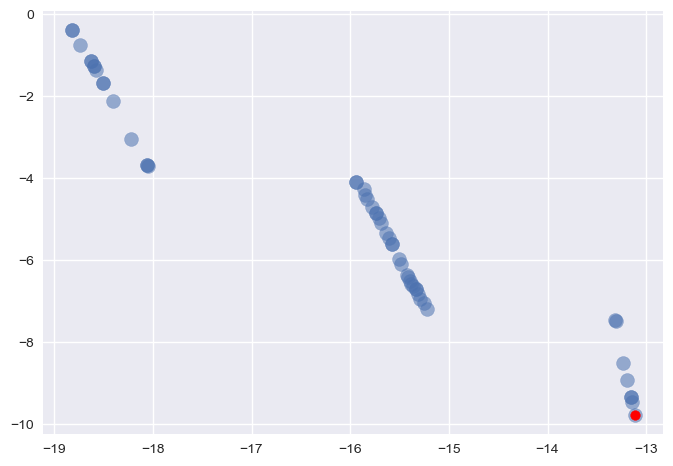

In [63]:
import pandas as pd
df = pd.DataFrame(fitness_values, columns=["obj1", "obj2"])
plt.scatter(x=df["obj1"],y=df["obj2"], alpha=.55, s=100)
plt.scatter(x=best_compromised_objective[0], y=best_compromised_objective[1], color="red")